In [1]:
import numpy as np 
import pandas as pd 

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import tensorflow as tf
import nltk, re, time
from nltk.corpus import stopwords
from string import punctuation
from collections import defaultdict
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from collections import namedtuple

C:\Users\arun\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
##restrict the review lengths to a 100 words max
df = pd.read_csv("Reviews.csv")
df = df[df['Score']!=3]
df['len_words'] = df.Text.apply(lambda x: len(x.split()))
df = df[df['len_words'] <= 100]

In [4]:
data = df[['Text', 'Score']]
data.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [5]:
##Convert the sentiment scores to 0 or a 1 and preprocess the text
data['sentiment']=[1 if (x>3) else 0 for x in data['Score']]
data['Text']= [x.lower() for x in data['Text']]
data['Text'] = data['Text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))##remove the non-alphanumerics
data.head()

C:\Users\arun\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\arun\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\arun\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

,Text,Score,sentiment
0,i have bought several of the vitality canned d...,5,1
1,product arrived labeled as jumbo salted peanut...,1,0
2,this is a confection that has been around a fe...,4,1
3,if you are looking for the secret ingredient i...,2,0
4,great taffy at a great price there was a wide...,5,1


In [6]:
data.shape

(403797, 3)

In [7]:
##tokenize the text and restrict the number of vocabulary words to a max of 10000 words and removes all characters from the
##filters string
tokenizer = Tokenizer(nb_words=10000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                   lower=True,split=' ')
tokenizer.fit_on_texts(data['Text'].values)
X = tokenizer.texts_to_sequences(data['Text'].values)
##padding the sequences to 100 words
X = pad_sequences(X)
Y = pd.get_dummies(data['sentiment']).values

C:\Users\arun\Anaconda3\lib\site-packages\keras_preprocessing\text.py:177: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [8]:
X.shape,Y.shape

((403797, 100), (403797, 2))

In [9]:
vals = [1 if each > 3 else 0 for each in data['Score'].values]
print("class imbalance datapoints",100*sum(vals)/len(vals))

class imbalance datapoints 85.2799797918261


In [10]:
###80-20 split on the dataset
X_train, X_test, Y_train, Y_test = train_test_split(X,data.sentiment, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(323037, 100) (323037,)
(80760, 100) (80760,)


In [11]:
###You can clearly observe the left padding
X[0],data['Text'].loc[0]

(array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    2,   13,  106,
         293,    9,    1, 5344,  589,   99,   66,  212,    3,   13,  111,
          28,   41,    6,   39,    9,   29,  172,    1,   35,  608,   51,
          23,    4, 2801,   55,    4, 1346,  530,    3,    5,  526,   85,
          12, 4693,    8, 1621,    3,  105, 7360,    7,   35,   85,   55,
         161]),
 'i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my labrador is finicky and she appreciates this product better than  most')

In [12]:
tokenizer.word_index['than'],tokenizer.word_index['most']

(55, 161)

In [13]:

def build_rnn(n_words, embed_size, current_batch, lstm_sizes, learning_rate):
    '''Build the Recurrent Neural Network'''

    tf.reset_default_graph()
    
    
    ###None, None indicates that you are about to recieve an unknown batch size and unknown sequence length
    with tf.name_scope('inputs'):
        inputs = tf.placeholder(tf.int32, [None, None], name='inputs')

    with tf.name_scope('labels'):
        labels = tf.placeholder(tf.int32, [None, None], name='labels')

    ###The keep prob for dropout
    keep_prob_ = tf.placeholder(tf.float32, name='keep_prob')

    
    with tf.name_scope("embeddings"):
        embedding = tf.Variable(tf.random_uniform((n_words, embed_size), -1, 1)) ##-1 because you don't know the batch size
        ##if multiple RNN layers are used try tf.Variable(tf.random_uniform((n_words, embed_size), -1)) instead
        embed = tf.nn.embedding_lookup(embedding, inputs)
        # batch_size_tf = length(embed)
        multi_RNN = []
        for each in lstm_sizes:
            lstm = tf.contrib.rnn.LSTMCell(each)
            ##For dropout you need to add another wrapper layer around normal LSTM
            drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
            multi_RNN.append(drop)
        cell = tf.contrib.rnn.MultiRNNCell(multi_RNN)

    with tf.name_scope("RNN_init_state"):
        # Getting an initial state of all zeros
        initial_state = cell.zero_state(current_batch, tf.float32)
    
    # Run the data through the RNN layers
    with tf.name_scope("RNN_forward"):
        # Run the data through the RNN layers
        outputs, states = tf.nn.dynamic_rnn(cell, embed, initial_state=initial_state)


    # Make the predictions
    with tf.name_scope('predictions'):
    
        # Create the fully connected layers by taking the last output from the LSTM outputs
        predictions = tf.contrib.layers.fully_connected(outputs[:, -1],
                                                  num_outputs = 2,
                                                  activation_fn = None,
                                                  weights_initializer = tf.truncated_normal_initializer(stddev=0.1))
        ##for tensorboard
        tf.summary.histogram('predictions', predictions)
    # Calculate the cost
    with tf.name_scope('cost'):
        # # Calculate the cost
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=predictions))
        ##for tensorboard
        tf.summary.scalar('cost', cost)

    # Train the model with back prop
    with tf.name_scope('train'):    

        # # Train the model
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(cost)

    # Determine the accuracy
    with tf.name_scope("accuracy"):

        # # Determine the accuracy
        correct_pred = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        ##for tensorboard
        tf.summary.histogram('accuracy', accuracy)

    # Merge all of the summaries
    merged = tf.summary.merge_all()    

    # Export the nodes 
    export_nodes = ['inputs', 'labels', 'keep_prob_', 'initial_state', 'states','accuracy',
                    'predictions', 'cost', 'train_op', 'merged']
    
    local_dict = locals()
    Graph_dict = {each:local_dict[each] for each in export_nodes}

######Alternatively you can also do the below    
#     Graph = namedtuple('Graph', export_nodes)
#     local_dict = locals()
#     Graph_dict = Graph(*[local_dict[each] for each in export_nodes])
##############################################

    return Graph_dict

In [14]:
model = build_rnn(n_words = 10000, 
                  embed_size = 200,
                  current_batch = 50,
                  lstm_sizes= [256],
                  learning_rate = 0.001
                 )
model['inputs']

<tf.Tensor 'inputs/inputs:0' shape=(?, ?) dtype=int32>

In [15]:
def convert_to_categorical(y, n_classes, batch_size):
    y_temp = np.zeros((batch_size, n_classes))
    for ind,every in enumerate(y):
        y_temp[ind][every[0]] = 1
    
    return y_temp

def get_batches(x, y, batch_size, n_classes):
    '''Create the batches for the training and validation data'''
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], convert_to_categorical(y[ii:ii+batch_size], n_classes=n_classes, batch_size=batch_size)

In [16]:
batch_vals = next(get_batches(X_train,Y_train[:,None],batch_size=20, n_classes = 2))

In [17]:
batch_vals[0].shape,batch_vals[1].shape

((20, 100), (20, 2))

In [18]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [20]:
batch_size = 50
saver = tf.train.Saver()
init = tf.global_variables_initializer()
epochs = 2
loss_train,acc_train = ([],[])
dataset_size = X.shape[0]
# Start training
with tf.Session() as sess:
    
    ##initalize all the tf global variables
    sess.run(init)
    since = time.time()
    
    for epoch in range(epochs):
        print(f"EPOCH : {epoch}")
        print("-"*200)
        for ind_tr,(x_,y_) in enumerate(get_batches(X_train,Y_train[:,None],batch_size=batch_size, n_classes= 2)):
            loss_val,acc_val,_ = sess.run([model['cost'],model['accuracy'],model['train_op']], feed_dict={model['inputs']: x_,
                                                         model['labels']: y_,model['keep_prob_']: 0.5})
            loss_train.append(loss_val)
            acc_train.append(acc_val)
            
            if ind_tr%1000 == 0:
                print(f"[{time_since(since)} , {int(ind_tr*batch_size*100/dataset_size)}% ,{round(loss_val,4)}, accuracy_train : {round(acc_val*100,2)}]")
                loss_test,acc_test = ([],[])
                for ind_te,(x_te,y_te) in enumerate(get_batches(X_test,Y_test[:,None],batch_size=batch_size, n_classes = 2)):
                    loss_te,acc_te = sess.run([model['cost'],model['accuracy']], feed_dict={model['inputs']: x_te,
                                                             model['labels']: y_te,model['keep_prob_']: 1})
                    loss_test.append(loss_te)
                    acc_test.append(acc_te)
                print(f"[{time_since(since)} , Test loss : {round(sum(loss_test)/len(loss_test),4)} , Test accuracy : {100*round(sum(acc_test)/len(acc_test),4)}]")
                print("\n\n")
                checkpoint = rf".\model_save\sentiment_{epoch}_{ind_tr}.ckpt"
                saver.save(sess, checkpoint)
        print("-"*200)


EPOCH : 0
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 0s , 0% ,0.7346000075340271, accuracy_train : 44.0]
 19s , Test loss : 0.6014 , Test accuracy : 78.66]



 40s , 12% ,0.16760000586509705, accuracy_train : 92.0]
 0s , Test loss : 0.1817 , Test accuracy : 92.97]



 25s , 24% ,0.15289999544620514, accuracy_train : 94.0]
 45s , Test loss : 0.1424 , Test accuracy : 94.53]



 7s , 37% ,0.051100000739097595, accuracy_train : 96.0]
 28s , Test loss : 0.1347 , Test accuracy : 94.67]



 50s , 49% ,0.225600004196167, accuracy_train : 94.0]
 11s , Test loss : 0.1177 , Test accuracy : 95.65]



 33s , 61% ,0.24410000443458557, accuracy_train : 92.0]
 54s , Test loss : 0.1136 , Test accuracy : 95.83]



 17s , 74% ,0.039400000125169754, accuracy_train : 100.0]
 39s , Test loss : 0.1091 , Test accuracy : 95.93]



-----------------------

In [19]:
import numpy as np

def predict_output(query_vec, model, sess_test):
    #     for _, x in enumerate(get_test_batches(x_test, batch_size), 1):
    test_state = sess_test.run(model['initial_state'])
    feed = {model['inputs']: x_query,
            model['keep_prob_']: 1,
            model['initial_state']: test_state}
    predictions = sess_test.run(model['predictions'], feed_dict=feed)
    return softmax(predictions[0])


def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

scores = [3.0, 1.0, 0.2, 4.0,4.5, 10.0, 11.5]
print(softmax(scores),sum(softmax(scores)))

[1.66118528e-04 2.24816980e-05 1.01016781e-05 4.51556975e-04
 7.44491590e-04 1.82171086e-01 8.16434164e-01] 0.9999999999999999


In [20]:
##testing
checkpoint = r".\model_save\sentiment_1_6000.ckpt"
sentence = 'this is a bad product'
x_query = np.array(tokenizer.texts_to_sequences([sentence]))

In [21]:
model_test = build_rnn(n_words = 10000, 
                  embed_size = 200,
                  current_batch = 1,
                  lstm_sizes = [256],
                  learning_rate = 0.001)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess_test:
    sess_test.run(init)
    # Load the model
#     saver = tf.train.import_meta_graph(checkpoint+".meta")
    saver.restore(sess_test, checkpoint)
#     saver.restore(sess, checkpoint)
#     print(predict_output(x_query, model, sess_test))
    print(f"probabilities : {predict_output(x_query, model_test, sess_test)}")

INFO:tensorflow:Restoring parameters from .\model_save\sentiment_1_6000.ckpt
probabilities : [0.9942009  0.00579904]


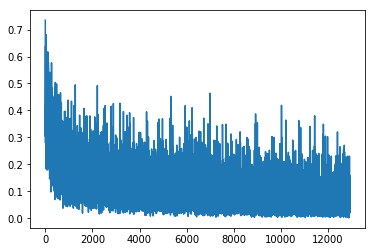

In [26]:
import matplotlib.pyplot as plt
plt.plot(loss_train)
plt.show()